# Modelado para un único modelo

Para el caso de un único modelo, la aplicación de los datos obtenidos se puede realizar de manera directa.

A continuación, se definen variables globales y las librerías que serán empleadas:

In [1]:
import os
from pathlib import Path
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import pickle
import numpy as np
from preprocess.preprocess import Preprocess
from confusion_matrix_pretty_print import print_confusion_matrix
import zipfile
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib.pyplot import figure


PLOT = True
# LBP_METHOD = 'default'
# LBP_METHOD = 'riu'
LBP_METHOD = 'riu2'
METHOD = 'get_pyramid_dataset'
# METHOD = 'get_datasets_by_scale'
HEIGHT = 608

En primer lugar se cargan las bases de datos a partir de los archivos comprimidos en formato zip:

In [2]:
# Database unzip
parent_path = 'jupyter-media'
train_file_name = parent_path + '/DB/train_train_' + LBP_METHOD + '_' + METHOD
with zipfile.ZipFile(f'{train_file_name}.zip', 'r') as zip_ref:
    zip_ref.extractall(f'{parent_path}/DB/')
test_file_name = parent_path + '/DB/train_test_' + LBP_METHOD + '_' + METHOD
with zipfile.ZipFile(f'{test_file_name}.zip', 'r') as zip_ref:
    zip_ref.extractall(f'{parent_path}/DB/')

# Dataframe
df_train = pd.read_pickle(f'{train_file_name}.pkl')
os.remove(f'{train_file_name}.pkl')
df_test = pd.read_pickle(f'{test_file_name}.pkl')
os.remove(f'{test_file_name}.pkl')

Se divide la variable dependiente de las independientes:

In [3]:
y_train = df_train.loc[:, 'label']
y_test = df_test.loc[:, 'label']
df_train.drop(columns=['label'], inplace=True)
df_test.drop(columns=['label'], inplace=True)

Se entrena el clasificador Naive-Bayes, siendo posible seleccionar si ajustar la probabilidad a priori:

In [4]:
def init_clf_and_fit(df, y):
    classifier = MultinomialNB(fit_prior=True)
    classifier.fit(df, y)
    return classifier

clf = init_clf_and_fit(df_train, y_train)

Y se realizan las predicciones y obtienen las métricas:

In [5]:
y_predicted = clf.predict(df_test)

print('Accuracy score: ' + str(accuracy_score(y_test, y_predicted)) + '\n')
print('F1 score: ' + str(f1_score(y_test, y_predicted)) + '\n')
print('Confusion matrix:\n')
print_confusion_matrix(y_test, y_predicted)

Accuracy score: 0.8805898846927476

F1 score: 0.48474216684346355

Confusion matrix:

     t/p      0     1 
        0 1123444 64101 
        1 98620 76542 


Por último se procesa el resultado gráfico.

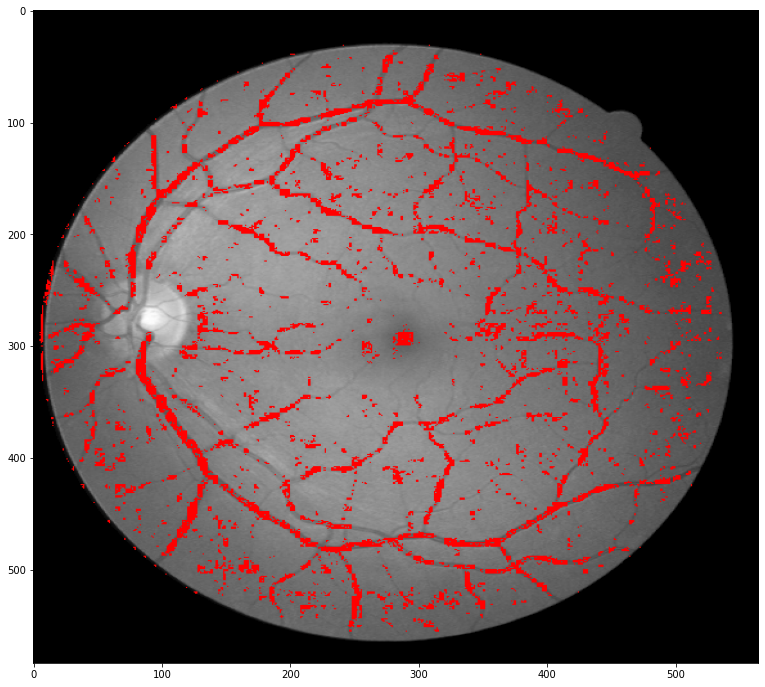

In [6]:
if PLOT:
    label_predicted = np.array(y_predicted)
    preprocess = Preprocess(height=608, width=576)
    img = Preprocess.read_img(f'{parent_path}/35_training.tif').ravel()
    mask = Preprocess.read_img(f'{parent_path}/35_training_mask.gif')
    img = img[mask.ravel() > 100]
    label = label_predicted[:len(img)]

    def array_to_mat(arr, mask_mat):
        mat = np.copy(mask_mat)
        mat[mat < 100] = 0
        mat[mat >= 100] = arr.ravel()
        return mat

    img = array_to_mat(img, mask)
    img = (img * (255 / np.max(img))).astype(int)
    label = array_to_mat(label, mask)
    img = np.asarray(Image.fromarray(np.uint8(img)).convert('RGB')).copy()
    img[label == 1] = [255, 0, 0]

    figure(figsize=(13,12))
    imshow(np.uint8(img), aspect='auto')

# Modelado para un modelo en cada escala

Se recogen los datos y se entrena un modelo para cada escala de la misma forma que en el caso previo:

In [7]:
METHOD = 'get_datasets_by_scale'

# Database unzip
parent_path = 'jupyter-media'
train_file_name = parent_path + '/DB/train_train_' + LBP_METHOD + '_' + METHOD
with zipfile.ZipFile(f'{train_file_name}.zip', 'r') as zip_ref:
    zip_ref.extractall(f'{parent_path}/DB/')
test_file_name = parent_path + '/DB/train_test_' + LBP_METHOD + '_' + METHOD
with zipfile.ZipFile(f'{test_file_name}.zip', 'r') as zip_ref:
    zip_ref.extractall(f'{parent_path}/DB/')

# Dataframe list
with open(f'{train_file_name}.pkl', 'rb') as f:
    df_train_list = pickle.load(f)
os.remove(f'{train_file_name}.pkl')
clf_list = [init_clf_and_fit(df_train.iloc[:, :-1], df_train.iloc[:, -1]) for df_train in df_train_list]
with open(f'{test_file_name}.pkl', 'rb') as f:
    df_test_list = pickle.load(f)
os.remove(f'{test_file_name}.pkl')

La aplicación de los modelos resulta algo más compleja. Se recogen las bases de datos correspondientes a cada escala y se aplican los modelos correspondientes. El resultado es un conjunto de predicciones de cada píxel a diferentes resoluciones, por lo que es preciso realizar un mapeo de los píxeles entre sí. Para ello se repiten los píxeles tantas veces como sea preciso para igualar el número de píxeles original de la imagen. Y posteriormente se aplica la máscara en su resolución original con la finalidad de conservar únicamente los píxeles relevantes. Las predicciones se ensamblan mediante un voto por mayoría, es decir se calcula la media de los valores y para aquellos superiores a 0.5 se etiqueta el píxel como perteneciente a un vaso sanguíneo.

Como vector de etiquetas reales se recoge el correspondiente a la dimensión original para cada imagen.

In [8]:
def ensemble_prediction(classifiers, dfs_test):
    # Calculating predictions
    y_predicted_list = [classifier.predict(test_set.iloc[:, :-1]).reshape(-1, 1)
                        for classifier, test_set in zip(classifiers, dfs_test['datasets'])]
    # Equaling the number of pixels
    y_predicted_list = [y_predicted_list[i].reshape(HEIGHT//(2 ** i), -1) for i in range(len(y_predicted_list))]
    y_predicted_list = [Preprocess.repeat_pixels(prediction, (2 ** i))
                        for i, prediction in enumerate(y_predicted_list)]
    # Mask application
    y_predicted_list = [prediction.ravel()[dfs_test['mask']].reshape(-1, 1) for prediction in y_predicted_list]
    # print(np.mean(np.concatenate(y_predicted_list, axis=1), axis=0))
    # Predictions
    y_predictions = np.mean(np.concatenate(y_predicted_list, axis=1), axis=1)
    # Actual values
    y_actual = np.array(dfs_test['datasets'][0].iloc[:, -1]).ravel()[dfs_test['mask']]
    return y_predictions, y_actual

In [9]:
y_predicted_test_list = [ensemble_prediction(clf_list, dfs_test) for dfs_test in df_test_list]
y_predicted = np.concatenate([y_predicted_test_pic[0] for y_predicted_test_pic in y_predicted_test_list])
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_test = np.concatenate([y_predicted_test_pic[1] for y_predicted_test_pic in y_predicted_test_list])

Las métricas que se obtienen son las siguientes:

In [10]:
print('Accuracy score: ' + str(accuracy_score(y_test, y_predicted)) + '\n')
print('F1 score: ' + str(f1_score(y_test, y_predicted)) + '\n')
print('Confusion matrix:\n')
print_confusion_matrix(y_test, y_predicted)

Accuracy score: 0.8714602625509372

F1 score: 0.0

Confusion matrix:

     t/p      0     1 
        0 1187545     0 
        1 175162     0 


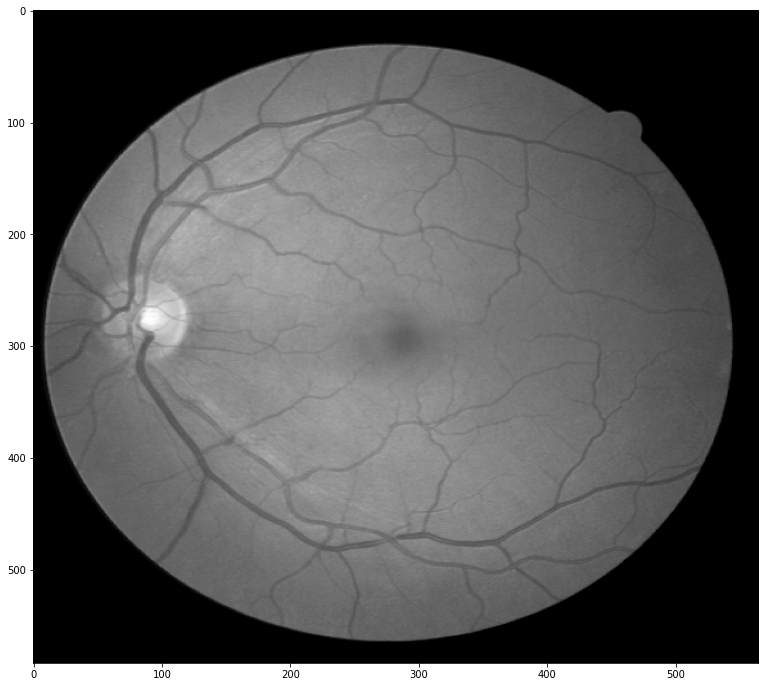

In [11]:
if PLOT:
    label_predicted = np.array(y_predicted)
    preprocess = Preprocess(height=608, width=576)
    img = Preprocess.read_img(f'{parent_path}/35_training.tif').ravel()
    mask = Preprocess.read_img(f'{parent_path}/35_training_mask.gif')
    img = img[mask.ravel() > 100]
    label = label_predicted[:len(img)]

    def array_to_mat(arr, mask_mat):
        mat = np.copy(mask_mat)
        mat[mat < 100] = 0
        mat[mat >= 100] = arr.ravel()
        return mat

    img = array_to_mat(img, mask)
    img = (img * (255 / np.max(img))).astype(int)
    label = array_to_mat(label, mask)
    img = np.asarray(Image.fromarray(np.uint8(img)).convert('RGB')).copy()
    img[label == 1] = [255, 0, 0]

    figure(figsize=(13,12))
    imshow(np.uint8(img), aspect='auto')